In [58]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [48]:
file_path = "../data/raw/online_retail_II.xlsx"
df = pd.read_excel(file_path, sheet_name="Year 2010-2011")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (541910, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [49]:
## Adding in logic for day of week to be a hyper parameter
## Step 1: Extract Day of Week from InvoiceDate

# Ensure InvoiceDate is a datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract day of week as string (Mon, Tue, etc.)
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name().str[:3]  # 'Mon', 'Tue', ...


In [50]:
## Step 2: Compute average profit per day
# Calculate row-level profit
df['Profit'] = df['Quantity'] * df['Price']

# Group by DayOfWeek and compute mean profit
day_profit_avg = df.groupby('DayOfWeek')['Profit'].mean()

# Normalize to a multiplier (divide by overall mean)
overall_mean = df['Profit'].mean()
day_multiplier = (day_profit_avg / overall_mean).to_dict()

print(day_multiplier)


{'Fri': 1.042029399506765, 'Mon': 0.9285567717974643, 'Sun': 0.6957717896192059, 'Thu': 1.1308029250485578, 'Tue': 1.0736532862181056, 'Wed': 1.0194772940063974}


In [51]:
## Step 3: Apply DayOfWeek multiplier in objective function

@use_named_args(search_space)
def objective(**params):
    price_multiplier = params['Price_Multiplier']
    promotion = params['Promotion']
    bundle_size = params['Bundle_Size']
    day = params['DayOfWeek']
    max_discount = params['Max_Discount_Percent']
    
    df['AdjPrice'] = df['Price'] * price_multiplier
    discount_map = {'No_Discount':0, 'Discount_5%':5, 'Discount_10%':10}
    applied_discount = min(discount_map[promotion], max_discount)
    df['FinalPrice'] = df['AdjPrice'] * (1 - applied_discount/100)
    
    df['EstimatedProfit'] = df['Quantity'] * df['FinalPrice'] * bundle_size
    
    # Apply data-driven day-of-week multiplier
    df['EstimatedProfit'] *= day_multiplier[day]
    
    return -df['EstimatedProfit'].sum()

In [52]:
# Profit per row
df['Profit'] = df['Quantity'] * df['Price']

# Randomly assign promotions for demo
np.random.seed(42)
df['Promotion'] = np.random.choice(['No_Discount', 'Discount_5%', 'Discount_10%'], size=len(df))

# Optional: show summary stats
print(df[['Price','Quantity','Profit']].describe())

# Show first few rows
df[['StockCode','Price','Quantity','Promotion','Profit']].head()


               Price       Quantity         Profit
count  541910.000000  541910.000000  541910.000000
mean        4.611138       9.552234      17.987795
std        96.759765     218.080957     378.810474
min    -11062.060000  -80995.000000 -168469.600000
25%         1.250000       1.000000       3.400000
50%         2.080000       3.000000       9.750000
75%         4.130000      10.000000      17.400000
max     38970.000000   80995.000000  168469.600000


,StockCode,Price,Quantity,Promotion,Profit
0,85123A,2.55,6,Discount_10%,15.30
1,71053,3.39,6,No_Discount,20.34
2,84406B,2.75,8,Discount_10%,22.00
3,84029G,3.39,6,Discount_10%,20.34
4,84029E,3.39,6,No_Discount,20.34


In [53]:
# --- 5 Hyperparameter Search Space ---
search_space = [
    Real(0.5, 2.0, name='Price_Multiplier'),                   # Continuous
    Categorical(['No_Discount','Discount_5%','Discount_10%'], name='Promotion'),  # Categorical
    Integer(1, 20, name='Bundle_Size'),                        # Integer
    Categorical(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], name='DayOfWeek'),  # Categorical
    Real(0, 20, name='Max_Discount_Percent')                  # Continuous
]

# --- Objective Function ---
from skopt.utils import use_named_args

@use_named_args(search_space)
def objective(**params):
    # Extract hyperparameters
    price_multiplier = params['Price_Multiplier']
    promotion = params['Promotion']
    bundle_size = params['Bundle_Size']
    day = params['DayOfWeek']      # For demo; not used in profit calc
    max_discount = params['Max_Discount_Percent']
    
    # Adjust price
    df['AdjPrice'] = df['Price'] * price_multiplier
    
    # Map promotion to discount
    discount_map = {'No_Discount': 0, 'Discount_5%': 5, 'Discount_10%': 10}
    applied_discount = min(discount_map[promotion], max_discount)
    
    # Final price after discount
    df['FinalPrice'] = df['AdjPrice'] * (1 - applied_discount / 100)
    
    # Apply bundle size
    df['EstimatedProfit'] = df['Quantity'] * df['FinalPrice'] * bundle_size
    
    # Return negative profit because gp_minimize minimizes
    return -df['EstimatedProfit'].sum()

# --- Run Bayesian Optimization ---
from skopt import gp_minimize

result = gp_minimize(
    func=objective,
    dimensions=search_space,
    acq_func='EI',       # Expected Improvement
    n_calls=20,          # Number of iterations
    n_initial_points=5,  # Random starting points
    random_state=42
)

# --- Display results ---
print("Best parameters found:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"{name}: {val}")

print(f"\nMaximum Estimated Profit: {-result.fun:.2f}")


Best parameters found:
Price_Multiplier: 2.0
Promotion: No_Discount
Bundle_Size: 20
DayOfWeek: Fri
Max_Discount_Percent: 20.0

Maximum Estimated Profit: 389910637.36


In [54]:
def objective(params):
    price_multiplier, promotion, bundle_size, day, max_discount = params
    
    df['AdjPrice'] = df['Price'] * price_multiplier
    discount_map = {'No_Discount': 0, 'Discount_5%': 5, 'Discount_10%': 10}
    applied_discount = min(discount_map[promotion], max_discount)
    df['FinalPrice'] = df['AdjPrice'] * (1 - applied_discount / 100)
    
    df['EstimatedProfit'] = df['Quantity'] * df['FinalPrice'] * bundle_size
    
    return -df['EstimatedProfit'].sum()


In [55]:
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=30,
    random_state=42
)

# Display results
best_params = dict(zip([dim.name for dim in search_space], result.x))
print("Best hyperparameters:")
for k,v in best_params.items():
    print(f"{k}: {v}")

print("\nMaximum estimated profit:", -result.fun)



Best hyperparameters:
Price_Multiplier: 2.0
Promotion: No_Discount
Bundle_Size: 20
DayOfWeek: Tue
Max_Discount_Percent: 0.0

Maximum estimated profit: 389910637.35999984


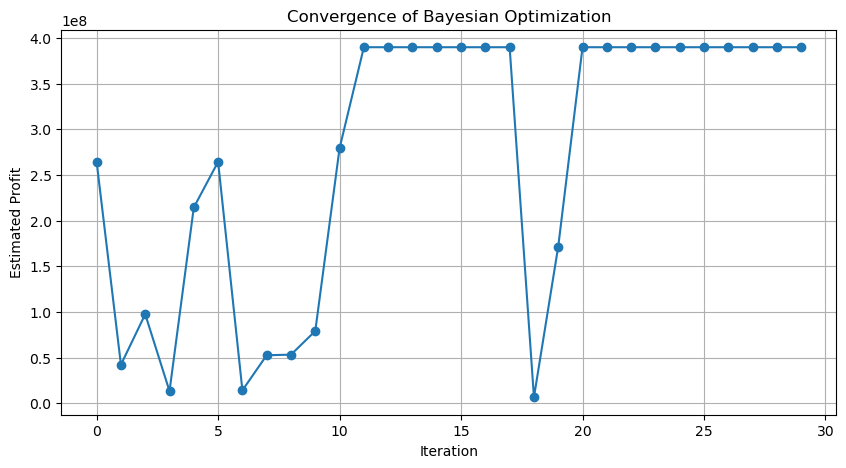

In [56]:
plt.figure(figsize=(10,5))
plt.plot(-np.array(result.func_vals), marker='o')
plt.xlabel("Iteration")
plt.ylabel("Estimated Profit")
plt.title("Convergence of Bayesian Optimization")
plt.grid(True)
plt.show()


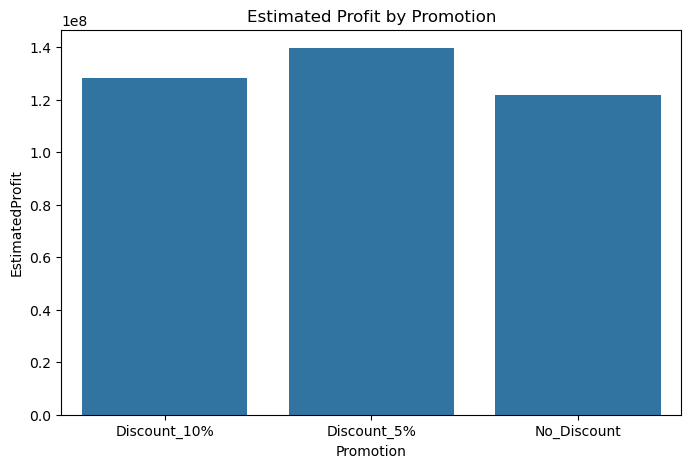

In [57]:
# Apply best hyperparameters to dataset
df['AdjPrice'] = df['Price'] * best_params['Price_Multiplier']
discount_map = {'No_Discount':0, 'Discount_5%':5, 'Discount_10%':10}
applied_discount = min(discount_map[best_params['Promotion']], best_params['Max_Discount_Percent'])
df['FinalPrice'] = df['AdjPrice'] * (1 - applied_discount/100)
df['EstimatedProfit'] = df['Quantity'] * df['FinalPrice'] * best_params['Bundle_Size']

# Show summary
summary = df.groupby('Promotion')['EstimatedProfit'].sum().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='Promotion', y='EstimatedProfit')
plt.title("Estimated Profit by Promotion")
plt.show()
